In [70]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from src.hmm import LinearHMM
from src.kalman_filter import KalmanFilter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
np.random.seed(1)

In [85]:
N_y = 1
dx = 1
dv = dx
dw = dx
dy = 1

A = 0.5 * np.random.normal(size=(dx, dx))
B = 0.1 * np.random.normal(size=(dx, dv))
C = np.random.normal(size=(dy, dx)) * np.ones([N_y, 1]) 
D = np.random.normal(size=(dy, dw)) * np.ones([N_y, 1])
Q = np.eye(dv)
R = np.eye(dw)
P = np.eye(dx)

linear_hmm = LinearHMM(A, B, C, D, Q, R, P, N_y=1)

In [86]:
n_steps = 0
linear_hmm.simulate(n_steps)

In [87]:
latent = linear_hmm.latent
obs = linear_hmm.obs

In [88]:
latent.shape, obs.shape

((1, 1), (1, 1))

In [89]:
np.mean(obs[-1, :] - linear_hmm.C * latent[-1, :])

2.469478804430745

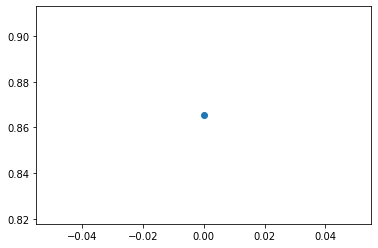

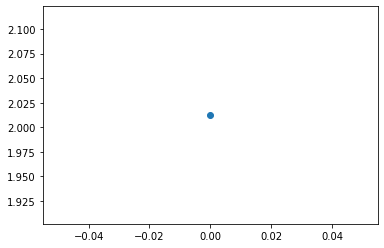

In [90]:
plt.scatter(range(n_steps + 1), latent[:, 0])
plt.show()
plt.scatter(np.repeat(range(n_steps + 1), N_y), obs[:, :])
plt.show()

In [91]:
# exact inference via kalman filter
kalman_filter = KalmanFilter(
    obs=obs,
    prior_latent_mean=np.zeros((1, dx)),
    prior_latent_var=P,
    A=A,
    B=B,
    C=C,
    D=D,
    R=R,
    Q=Q
)

In [92]:
posterior_mean, posterior_var = kalman_filter.fit()

In [93]:
# posterior_mean.shape, posterior_var.shape
posterior_mean, posterior_var, latent[-1, :]

(array([[-0.74316183]]), array([[0.80495027]]), array([0.86540763]))

In [94]:
posterior_samples = np.random.multivariate_normal(
    posterior_mean[0, :], posterior_var, 1000)

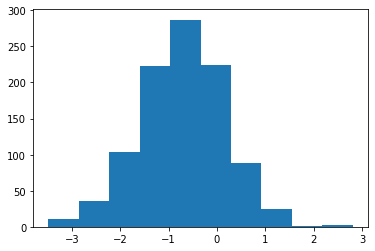

In [95]:
# plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1])
# plt.scatter(latent[-1, 0], latent[-1, 1], color="r")

_ = plt.hist(posterior_samples)

# Sequential IS

In [153]:
from scipy.stats import multivariate_normal

In [154]:
proposal_var = 2.
proposal = multivariate_normal(np.zeros(dx), proposal_var * np.eye(dx))

In [155]:
sis_samples, sis_log_w = linear_hmm.sis(N=10000, proposal=proposal)

In [156]:
sis_w = np.exp(sis_log_w[-1, :]).reshape((-1, 1))
print("SIS estimate of E[x_n | y_{1:n}]:", np.sum((sis_samples[-1, :, :] * sis_w), axis=0) / np.sum(sis_w))
print("True E[x_n | y_{1:n}]", posterior_mean[0, :])

SIS estimate of E[x_n | y_{1:n}]: [-0.82837566]
True E[x_n | y_{1:n}] [-0.74316183]


In [170]:
# # sample according to weights
# ind = np.random.choice(range(sis_samples.shape[1]), size=sis_samples.shape[1], replace=True, p=(sis_w / sis_w.sum()).reshape((-1,)))
# resampled_sis_samples = sis_samples[-1, :]

Text(0.5, 1.0, 'nstep = 0')

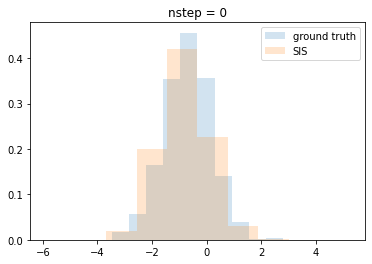

In [176]:
plt.hist(posterior_samples, alpha=0.2, label="ground truth", density=True)
plt.hist(sis_samples[-1, :], weights=sis_w, alpha=0.2, label="SIS", density=True)
plt.legend()
plt.title("nstep = 0")